In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # if previous search failed or too long, comment the previous line and simply write down manually the path below :
    path_to_file = '/content/gdrive/My Drive/CS5340_project/cs5340-covid-pgm/notebook/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/CS5340_project/cs5340-covid-pgm/notebook/
/content/gdrive/My Drive/CS5340_project/cs5340-covid-pgm/notebook


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pgmpy
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork
from sklearn.model_selection import train_test_split

     |████████████████████████████████| 1.9 MB 4.4 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pickle
import pgmpy

In [6]:
# Learn model again with dates added in 
covid_policies_df = pd.read_csv(
    "../data/processed/Final_Data_Combined.csv", index_col=0
)
print(covid_policies_df.shape)
covid_policies_df["date"] = pd.to_datetime(covid_policies_df["Date"])
covid_policies_df["Country"] = covid_policies_df["Country"].str.lower()
covid_policies_df["Country"] = covid_policies_df["Country"].str.replace(" ", "_")
covid_policies_df.rename(columns={"Country": "country"}, inplace=True)
covid_policies_df.set_index(["country", "date"], inplace=True)
covid_policies_df.drop(columns=["Date"], inplace=True)
covid_policies_df.rename(
    columns={col: col.lower() for col in covid_policies_df.columns}, inplace=True
)
print(covid_policies_df.shape)
for column in covid_policies_df.columns:
    if pd.api.types.is_numeric_dtype(covid_policies_df[column].dtype):
        continue

    covid_policies_df[column] = (
        covid_policies_df[column].apply(lambda v: v[:1]).astype("int16")
    )
country_to_population_map = { # for 2021
    "argentina": 45.85e6,
    "australia": 25750198,
    "brazil": 212.61e6,
    "canada": 37.74e6,
    "switzerland": 8.66e6,
    "germany": 83900473,
    "egypt": 101.48e6,
    "finland": 5.54e6,
    "india": 1.39e9,
    "united_states": 332915073,
    "new_zealand": 5122600,
    "south_africa": 60e6,
    "hong_kong": 7500000,
    "china": 1448000000,
    "indonesia": 272000000,
    "singapore": 5450000,
    "malaysia": 32000000,
    "israel": 9.45e6
}
def compute_cases_bin(cases_per_mil):
    computed_bin = None
    if cases_per_mil <= 10000:
        computed_bin = 0
    elif cases_per_mil < 30000:
        computed_bin = 1
    elif cases_per_mil < 50000:
        computed_bin = 2
    elif cases_per_mil < 70000:
        computed_bin = 3
    elif cases_per_mil < 100000:
        computed_bin = 4
    elif cases_per_mil < 120000:
        computed_bin = 5
    else:
        computed_bin = 6

    return computed_bin

covid_policies_df["cases_per_mil"] = covid_policies_df.apply(lambda row: (row.confirmed_cases * 1000000)/ country_to_population_map[row.name[0]], axis=1)
covid_policies_df["cases_per_mil_cat"] = covid_policies_df["cases_per_mil"].apply(compute_cases_bin)
print(covid_policies_df.shape)
covid_policies_df.drop("cases_per_mil", axis = 1, inplace=True)
covid_policies_df["deaths_per_mil"] = covid_policies_df.apply(lambda row: (row.confirmed_deathes * 1000000)/ country_to_population_map[row.name[0]], axis=1)
covid_policies_df["deaths_per_mil_cat"] = covid_policies_df["deaths_per_mil"].apply(compute_cases_bin)
covid_policies_df.drop("deaths_per_mil", axis = 1, inplace=True)

covid_policies_df = covid_policies_df.reset_index()
for c in covid_policies_df.country.unique():
    exec(f"df_{c} = covid_policies_df[covid_policies_df.country == \"{c}\"]")
    eval(f"print(\"Size of df_{c}\",df_{c}.shape)")
for c in covid_policies_df.country.unique():
  exec(f"df_{c} = df_{c}.add_suffix('_{c}')")
m4 = df_china
for c in covid_policies_df.country.unique():
  if c != "china":
    # china already assigned
    exec(f"m4 = pd.merge(m4, df_{c}, left_on='date_china', right_on='date_{c}')")
m4.rename(columns={"date_china": "date"}, inplace=True)
columns_to_drop = m4.filter(regex="^country_|^date_|^confirmed_cases_|^confirmed_deathes_").columns
new_df = m4.drop(columns_to_drop, axis = 1)
new_df["date"] = pd.to_datetime(new_df['date'])
y_cols = list(new_df.filter(regex="^cases_per_mil_cat_").columns)
x_cols = list(set(new_df.columns) - set(y_cols))
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    new_df[x_cols], new_df[y_cols], random_state = 42, shuffle=False
)



(11993, 19)
(11993, 17)
(11993, 19)
Size of df_argentina (661, 21)
Size of df_australia (667, 21)
Size of df_brazil (667, 21)
Size of df_canada (667, 21)
Size of df_switzerland (667, 21)
Size of df_china (667, 21)
Size of df_germany (667, 21)
Size of df_egypt (667, 21)
Size of df_finland (667, 21)
Size of df_hong_kong (666, 21)
Size of df_indonesia (667, 21)
Size of df_india (667, 21)
Size of df_israel (667, 21)
Size of df_malaysia (661, 21)
Size of df_new_zealand (667, 21)
Size of df_singapore (667, 21)
Size of df_united_states (667, 21)
Size of df_south_africa (667, 21)


HMM
Ref: https://rubikscode.net/2021/09/06/stock-price-prediction-using-hidden-markov-model/

In [7]:
!pip install hmmlearn

     |████████████████████████████████| 129 kB 5.0 MB/s 


In [14]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
 
# args = docopt(doc=__doc__, argv=None, help=True,
#               version=None, options_first=False)
 
# Supress warning in hmmlearn
warnings.filterwarnings("ignore")
# Change plot style to ggplot (for better and more aesthetic visualisation)
plt.style.use('ggplot')
 
 
class CasePredictor(object):
    def __init__(self, country, test_size=0.33,
                 n_hidden_states=6, n_latency_days=10,
                 n_steps_frac_change=50, n_steps_frac_high=10,
                 n_steps_frac_low=10):
        self._init_logger()
 
        self.country = country
        self.n_latency_days = n_latency_days
 
        self.hmm = GaussianHMM(n_components=n_hidden_states)
 
        self._split_train_test_data(test_size)
 
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
 
    def _split_train_test_data(self, test_size):
        data = eval(f"df_{self.country.lower()}")
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
 
    @staticmethod
    def _extract_features(data, country):
        #'school_closures_China',
        #  'workplace_closures_China', 'cancel_public_events_China',
        #  'restrict_public_gathering_China', 'closure_public_transport_China',
        #  'shn_requirement_China', 'restriction_internal_movement_China',
        #  'internation_travel_control_China', 'pi_campaign_China',
        #  'testing_policy_China', 'contact_tracing_China',
        #  'facial_covering_China', 'vaccine_policy_China'
        school_closure = np.array(data[f'school_closures_{country}'])
        workplace_closure = np.array(data[f"workplace_closures_{country}"])
        cancel_public_events = np.array(data[f'cancel_public_events_{country}'])
        restrict_public_gathering = np.array(data[f'restrict_public_gathering_{country}'])
        closure_public_transport = np.array(data[f"closure_public_transport_{country}"])
        cases_per_mil_cat = np.array(data[f"cases_per_mil_cat_{country}"])
 
        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        # frac_change = (close_price - open_price) / open_price
        # frac_high = (high_price - open_price) / open_price
        # frac_low = (open_price - low_price) / open_price
 
        return np.column_stack((school_closure, workplace_closure, cancel_public_events, restrict_public_gathering, closure_public_transport, cases_per_mil_cat))
 
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = CasePredictor._extract_features(self._train_data, self.country)
        self._logger.info('Features extraction Completed <<<')
 
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        # frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        # frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        # frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
        school_closure_range = np.arange(0, 4)
        workplace_closure_range = np.arange(0, 4)
        cancel_public_events_range = np.arange(0, 4)
        restrict_public_gathering_range = np.arange(0, 4)
        closure_public_transport_range = np.arange(0, 4)
        cases_per_mil_cat_range = np.arange(0, 7)
 
        self._possible_outcomes = np.array(list(itertools.product(
            school_closure_range, workplace_closure_range, cancel_public_events_range, restrict_public_gathering_range, closure_public_transport_range, cases_per_mil_cat_range)))
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = CasePredictor._extract_features(
            previous_data, self.country)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    def predict_cases_and_policies(self, day_index):
        school_closure, workplace_closure, cancel_public_events, restrict_public_gathering, closure_public_transport, cases_per_mil_cat = self._get_most_probable_outcome(
            day_index)
        if cases_per_mil_cat == 0:
          low = 0
          high = 10000
        elif cases_per_mil_cat == 1:
          low = 10000
          high = 30000
        elif cases_per_mil_cat == 2:
          low = 30000
          high = 50000
        elif cases_per_mil_cat == 3:
          low = 50000
          high = 70000
        elif cases_per_mil_cat == 4:
          low = 70000
          high = 100000
        elif cases_per_mil_cat == 5:
          low = 100000
          high = 120000
        cases_per_mil = (high-low)/2
        #return cases_per_mil
        return school_closure, workplace_closure, cancel_public_events, restrict_public_gathering, closure_public_transport, cases_per_mil
 
    def predict_cases_for_days(self, days, with_plot=False):
        predicted_cases = []
        for day_index in tqdm(range(days)):
            predicted_cases.append(self.predict_cases_and_policies(day_index)[0])
 
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data[f'date_{self.country}'], dtype="datetime64[ms]")
            # actual_cases = test_data[f'cases_per_mil_{self.country}']
            actual_cases = test_data[f"school_closures_{self.country}"]
 
            fig = plt.figure()
 
            axes = fig.add_subplot(111)
            axes.plot(days, actual_cases, 'bo-', label="actual")
            axes.plot(days, predicted_cases, 'r+-', label="predicted")
            axes.set_title('{country}'.format(country=self.country))
 
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show()
 
        return predicted_cases
 
 

2022-04-20 12:37:26,238 __main__     INFO     >>> Extracting Features
2022-04-20 12:37:26,238 __main__     INFO     >>> Extracting Features
2022-04-20 12:37:26,238 __main__     INFO     >>> Extracting Features
2022-04-20 12:37:26,251 __main__     INFO     Features extraction Completed <<<
2022-04-20 12:37:26,251 __main__     INFO     Features extraction Completed <<<
2022-04-20 12:37:26,251 __main__     INFO     Features extraction Completed <<<
100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


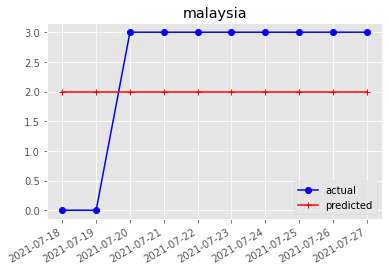

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [16]:
case_predictor = CasePredictor(country='malaysia', n_latency_days=60)
case_predictor.fit()
case_predictor.predict_cases_for_days(10, with_plot=True)

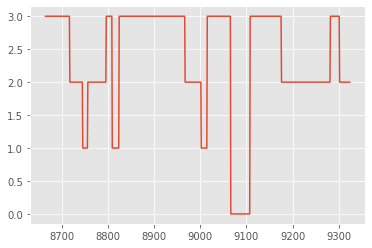

In [17]:
plt.plot(df_malaysia["school_closures_malaysia"])

Reversing hidden and observed variables

In [35]:
import warnings
import logging
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from docopt import docopt
 
# args = docopt(doc=__doc__, argv=None, help=True,
#               version=None, options_first=False)
 
# Supress warning in hmmlearn
warnings.filterwarnings("ignore")
# Change plot style to ggplot (for better and more aesthetic visualisation)
plt.style.use('ggplot')
 
 
class CasePredictor_reverse(object):
    def __init__(self, country, test_size=0.33,
                 n_hidden_states=6, n_latency_days=10,
                 n_steps_frac_change=50, n_steps_frac_high=10,
                 n_steps_frac_low=10):
        self._init_logger()
 
        self.country = country
        self.n_latency_days = n_latency_days
 
        self.hmm = GaussianHMM(n_components=n_hidden_states)
 
        self._split_train_test_data(test_size)
 
        self._compute_all_possible_outcomes(
            n_steps_frac_change, n_steps_frac_high, n_steps_frac_low)
 
    def _init_logger(self):
        self._logger = logging.getLogger(__name__)
        handler = logging.StreamHandler()
        formatter = logging.Formatter(
            '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
        handler.setFormatter(formatter)
        self._logger.addHandler(handler)
        self._logger.setLevel(logging.DEBUG)
 
    def _split_train_test_data(self, test_size):
        data = eval(f"df_{self.country.lower()}")
        _train_data, test_data = train_test_split(
            data, test_size=test_size, shuffle=False)
 
        self._train_data = _train_data
        self._test_data = test_data
 
    @staticmethod
    def _extract_features(data, country):
        workplace_closure = np.array(data[f"workplace_closures_{country}"])
        # cases_per_mil_cat = np.array(data[f"cases_per_mil_cat_{country}"])
 
        # Compute the fraction change in close, high and low prices
        # which would be used a feature
        # frac_change = (close_price - open_price) / open_price
        # frac_high = (high_price - open_price) / open_price
        # frac_low = (open_price - low_price) / open_price
 
        # return np.column_stack((workplace_closure, cases_per_mil_cat))
        return workplace_closure.reshape(-1, 1)
 
    def fit(self):
        self._logger.info('>>> Extracting Features')
        feature_vector = CasePredictor_reverse._extract_features(self._train_data, self.country)
        self._logger.info('Features extraction Completed <<<')
 
        self.hmm.fit(feature_vector)
 
    def _compute_all_possible_outcomes(self, n_steps_frac_change,
                                       n_steps_frac_high, n_steps_frac_low):
        # frac_change_range = np.linspace(-0.1, 0.1, n_steps_frac_change)
        # frac_high_range = np.linspace(0, 0.1, n_steps_frac_high)
        # frac_low_range = np.linspace(0, 0.1, n_steps_frac_low)
        workplace_closure_range = np.arange(0, 4)
        cases_per_mil_cat_range = np.arange(0, 7)
 
        self._possible_outcomes = cases_per_mil_cat_range
 
    def _get_most_probable_outcome(self, day_index):
        previous_data_start_index = max(0, day_index - self.n_latency_days)
        previous_data_end_index = max(0, day_index - 1)
        previous_data = self._test_data.iloc[previous_data_end_index: previous_data_start_index]
        previous_data_features = CasePredictor_reverse._extract_features(
            previous_data, self.country)
 
        outcome_score = []
        for possible_outcome in self._possible_outcomes:
            total_data = np.row_stack(
                (previous_data_features, possible_outcome))
            # print(total_data)
            outcome_score.append(self.hmm.score(total_data))
        most_probable_outcome = self._possible_outcomes[np.argmax(
            outcome_score)]
 
        return most_probable_outcome
 
    def predict_cases_and_policies(self, day_index):
        cases_per_mil_cat = self._get_most_probable_outcome(day_index)
        return cases_per_mil_cat
        # return school_closure, workplace_closure, cancel_public_events, restrict_public_gathering, closure_public_transport, cases_per_mil
 
    def predict_cases_for_days(self, days, with_plot=False):
        predicted_cases = []
        for day_index in tqdm(range(days)):
            predicted_cases.append(self.predict_cases_and_policies(day_index))
 
        if with_plot:
            test_data = self._test_data[0: days]
            days = np.array(test_data[f'date_{self.country}'], dtype="datetime64[ms]")
            actual_cases = test_data[f'cases_per_mil_cat_{self.country}']
            # actual_cases = test_data[f"school_closures_{self.country}"]
 
            fig = plt.figure()
 
            axes = fig.add_subplot(111)
            axes.plot(days, actual_cases, 'bo-', label="actual")
            axes.plot(days, predicted_cases, 'r+-', label="predicted")
            axes.set_title('{country}'.format(country=self.country))
 
            fig.autofmt_xdate()
 
            plt.legend()
            plt.show()
 
        return predicted_cases
 
 

2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,128 __main__     INFO     >>> Extracting Features
2022-04-20 12:48:46,160 __main__     INFO     Features extraction Completed <<<
2022-04-20 12:48:46,160 __main__     INFO     Features extraction Completed <<<


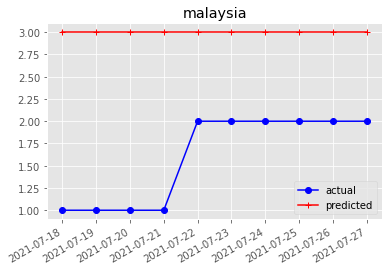

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [36]:
case_predictor = CasePredictor_reverse(country='malaysia', n_latency_days=60)
case_predictor.fit()
case_predictor.predict_cases_for_days(10, with_plot=True)